In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
upperLimit = 0.975
lowerLimit = 0.95
class TreeNode():
    def __init__(self, label , leftNode = None, rightNode = None):
        self.node = label
        if leftNode is not None:
            if rightNode is None:
                raise Exception('Only left child is defined.')
            self.leftChild = leftNode
            self.leftEsimate = np.random.uniform(lowerLimit,upperLimit)
            self.leftParam = np.random.uniform(lowerLimit,upperLimit)
            self.rightChild = rightNode
            self.rightEsimate = np.random.uniform(lowerLimit,upperLimit)
            self.rightParam = np.random.uniform(lowerLimit,upperLimit)
            self.isLeaf = False
        else:
            if rightNode is not None:
                raise Exception('Only right child is defined.')
            self.isLeaf = True
        self.spins = None
        self.magnetizations = None

    def generateSpins(self, numberSamples):
        self.spins = np.ones(shape = (numberSamples,1))
        self.propogate(self.spins)
    
    def propogate(self,signal):
        signal = np.array(signal)
        self.spins = signal
        if not self.isLeaf:
            pL = (1-self.leftParam)/2
            pR = (1-self.rightParam)/2
            lFlip = 1-2*np.random.binomial(1,pL,size = signal.shape)
            rFlip = 1-2*np.random.binomial(1,pR,size = signal.shape)
            self.leftChild.propogate(lFlip*signal)
            self.rightChild.propogate(rFlip*signal)
        else:
            self.magnetizations = signal    
    
    def magnetize(self):
        if self.magnetizations is None:
            self.leftChild.magnetize()
            self.rightChild.magnetize()
            recurse = np.vectorize(lambda x,y:(x+y)/(1+x*y))
            thetaL = self.leftEsimate
            thetaR = self.rightEsimate
            zL = self.leftChild.magnetizations
            zR = self.rightChild.magnetizations
            self.magnetizations = recurse(thetaL*zL, thetaR*zR)
            self.leftChild.magnetizations = None
            self.rightChild.magnetizations = None

    def constructMagnetization(self, numberSamples):
        self.generateSpins(numberSamples = numberSamples)
        self.magnetize()
        return self.magnetizations
        
def kingmanTree(numberLeaves):
    leafs = {i:TreeNode(i) for i in range(numberLeaves)}
    nextLabel = numberLeaves
    while len(leafs)>=2:
        keys = list(leafs.keys())
        l,r = random.sample(keys,2)
        leafs[nextLabel] = TreeNode(nextLabel, leafs[l], leafs[r])
        leafs.pop(l)
        leafs.pop(r)
        nextLabel+=1
    node = leafs[nextLabel-1] 
    return node





In [3]:
n_leafs = 1000
root = kingmanTree(n_leafs)


In [4]:
from tqdm import trange
samplesPerTry = 10000
trials = 100
Z = []
for i in trange(trials):
    attempt = root.constructMagnetization(samplesPerTry)
    root.magnetizations = None
    Z.extend(list(attempt))
Z = np.array(Z,dtype = np.float64)



100%|██████████| 100/100 [04:20<00:00,  2.61s/it]


In [ ]:
'''filename = "data.csv" 
Z = []
with open(filename, 'r') as f:
    for line in f:
        Z.append(line[:-1])

W = [np.float128(z) for z in Z]
R = np.array(W,dtype = np.float128)'''

In [5]:
Z = Z.reshape(-1)

In [9]:
num_bins = int(len(Z)/10000)+1
counts, bins = np.histogram(Z,bins = num_bins)


In [10]:
from scipy import stats
num_bins = int(len(Z)/1000)+1
counts, bins = np.histogram(Z,bins = num_bins)

t = np.linspace(-1,1,1000,endpoint=True)
kde = stats.gaussian_kde(Z,bw_method = .001)
kd = kde(t)
counts, bins = np.histogram(Z, bins = num_bins)
counts2 = counts/len(Z)

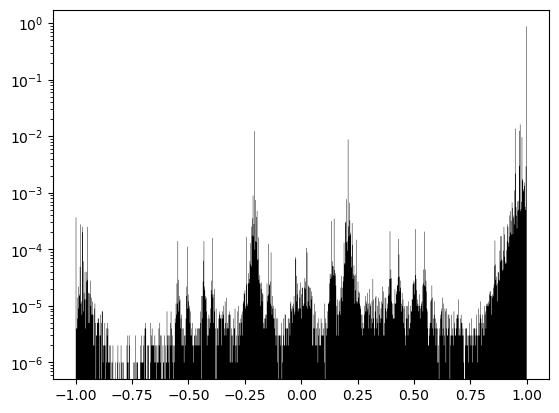

In [11]:
fig, ax = plt.subplots()
ax.stairs(counts2,bins, fill = True, color = 'k')
#ax.plot(t, kd)
plt.yscale('log')

In [15]:
delta = .025
pup = len([z for z in Z if z>1-2*delta])/len(Z)
pdown = len([z for z in Z if z<-.5])/len(Z)

In [16]:
print(pup)
print(pdown)

0.935535
0.002732


In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
sns.barplot(data = Z)
sns.kdeplot(data = Z, color = 'k')
ax.yscale('log')
plt.show()

In [105]:
sum([z<Z[6] for z in Z])

0

In [106]:
Z[0:10]

[-0.9981151692763788,
 -0.9981151692763788,
 -0.9981151692763788,
 -0.9981151692763788,
 -0.9981151692763788,
 -0.9981151692763788,
 -0.9981151692763788,
 -0.9981151692763788,
 -0.9981151692763788,
 -0.9981151692763788]

[0.9995593200089864,
 0.999559501168686,
 0.999555619665108,
 0.9995595011765337,
 0.9995595011530224,
 0.9995595011844387,
 0.9995187756761476,
 0.9442218431002117,
 0.9983373601347297,
 0.9995594977975529,
 0.9995595006380464,
 0.19630938913840826,
 0.9995595005183063,
 0.9992108480544905,
 0.9995595010737414,
 0.9995557616886567,
 0.9995594458219471,
 0.9995594726984961,
 0.9995528057148115,
 0.9995594997249186,
 0.9866200688831674,
 0.9995594780739661,
 0.9995592833020857,
 0.9995527761779877,
 0.9995594804139504,
 0.434489499025975,
 0.9995595006229766,
 0.9995595011903947,
 0.9995595011891515,
 0.999559501190325,
 0.9995594542200799,
 0.9995003851755305,
 0.999557308377447,
 0.9995595000121139,
 0.9995595011903865,
 0.999559472514249,
 0.9995594982566872,
 0.19635185297096086,
 0.9995594991129568,
 0.19639562093259536,
 0.999559197252502,
 0.9995587681247483,
 0.999004576456113,
 -0.16804730502024165,
 0.9995595011771409,
 0.9995594986017027,
 0.999559501130217,
 0.99930981099290